# News-Link: Data Visualization and Exploration

The following code explores aspects of the data used to create the corpus for **News-Link**. In addition, there is also exploration of the similarity metrics compiled to validate the model. While NLP approaches may be somewhat subjective, making validation challenging, below is an exploration of how the outputs of my model compare to links inserted by journalists themsevles.  

The following script requires data files which are stored in the *"cleaned data"* folder. These data files were created using the validation scripts which can be found in the *"scripts'* folder. 

In [1]:
#Loading in required packages
import pandas as pd
import numpy as np
import sys
import statistics
import matplotlib.pyplot as plt

In [2]:
#Loading in the fully cleaned corpus and validation metrics. Rounding all validation metrics
sys.path.insert(1, '/Users/Cylita/Desktop/insight-ds-project_news-link/data/cleaned/')

#TF-IDF and cosine similarity validation metrics
val_tfidf = round(pd.read_csv('/Users/Cylita/Desktop/insight-ds-project_news-link/data/cleaned/validation_metrics.csv').dropna(), 2)
#GloVe embeddings and cosine similarity validation metrics
val_glove = round(pd.read_csv('/Users/Cylita/Desktop/insight-ds-project_news-link/data/cleaned/validation_metrics_GloveCosine.csv').dropna(), 2)
#GloVe embeddings and word mover's distance validation metrics
val_wmd = round(pd.read_csv('/Users/Cylita/Desktop/insight-ds-project_news-link/data/cleaned/validation_metrics_wmd.csv').dropna(), 2)

#Full, cleaned news corpus
news_corpus = pd.read_csv('/Users/Cylita/Desktop/insight-ds-project_news-link/data/cleaned/Final_Cleaned_Corpus.txt')

### Story Length Visualization

Readership tends to drop off for longer stories. As such it is useful to provide potentially disengaged users with links to related content at the drop off point. I wanted the **News-Link** web app to notifiy journalists when their story was longer than average and encourage them to insert related links throughout their story, rather than just at the end. In order to set the condition for a "long" story, I looked at the variation in story lengths throughout the corpus and determined a cutoff based on the 85th percetile (~500 words). 

In [3]:
#Separating out fully cleaned stories
stories = news_corpus['cleaned_text']

#Calculating length of stories and storing in a list
story_length = []

for story in stories:
    forcount = len(story.split())
    story_length.append(forcount)

The distribution of story length is highly skewed (see visualization below), with most stories being on the shorter side. Given the highly skewed distribution I compute median story length (rather than average) and compute the 85th percentile. 

In [6]:
#Calculating median story length
story_median = statistics.median(story_length)

#Converting list of array 
length_array = np.asarray(story_length)

#Calculating the 90th percentile
percentile_90 = np.percentile(length_array, 90)
#Calculating the 85th percentile
percentile_85 = np.percentile(length_array, 85)

print(percentile_90, percentile_85)

613.4000000000001 539.0


<Figure size 504x504 with 0 Axes>

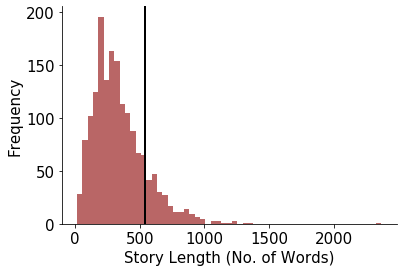

In [10]:
# create a figure and axes
fig = plt.figure(figsize=(7,7))
fig, storyhist = plt.subplots()
plt.hist(story_length, bins='auto', alpha=0.6, color="darkred")

plt.rc('lines', linewidth=2, color='black')
plt.axvline(x = percentile_85)

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

#removing top and right borders
storyhist.spines['top'].set_visible(False)
storyhist.spines['right'].set_visible(False)

storyhist.set_xlabel('Story Length (No. of Words)', fontsize=15) #labelling x and y axes
storyhist.set_ylabel('Frequency', fontsize=15)

plt.savefig("News_Hist.jpeg", transparent = True)

##### Fig 1. Histogram of corpus news story lengths. Black line represents the 85th percentile

### Comparison of Model Selected Links to Journalist Selected Links

As one strategy to validate this model, while scraping the main text body of news articles from the cbc.ca I also scraped the links curated and inserted manually by journalists. I was interested to see if - for a given news story - the top story identified by my model has a similarity score close to that of a stor inserted directly by a journalist. 

In addition to TF-IDF and cosine similarity (which is how the **News-Link** web app returns similar news stories), I also explored how this comparison changed if GloVe embeddings and cosine similairty or GloVe embeddings and word mover's distance were used to calculate article similairty. 

#### TF-IDF Vectors & Cosine Similarity

<Figure size 504x504 with 0 Axes>

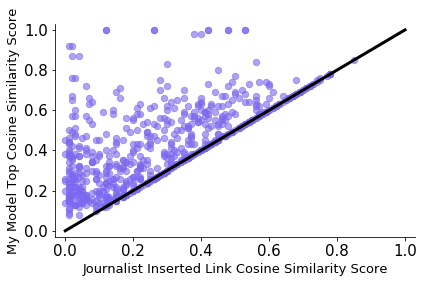

In [16]:
#Creating a figure and axes
fig = plt.figure(figsize=(7,7))
fig, ax = plt.subplots()

#scatter my similarity scores against the similarity scores for journalist inserted articles
ax.scatter(val_tfidf['JournalScore'], val_tfidf['MyModel'], 
           c='mediumslateblue', alpha = 0.6, s=40)
#Setting x and y limits
plt.xlim(-0.03, 1.03)
plt.ylim(-0.03, 1.03)

#Adjusting axes
plt.rc('axes', labelsize=10)  # ontsize of the x and y labels
plt.rc('xtick', labelsize=15) # fontsize of the tick labels
plt.rc('ytick', labelsize=15) # fontsize of the tick labels

ax.set_xlabel('Journalist Inserted Link Cosine Similarity Score', fontsize=13)
ax.set_ylabel('My Model Top Cosine Similarity Score', fontsize = 13)

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 

#Adding 1:1 line on plot 
plt.plot([0, 1.0], [0, 1.0], color='black', linestyle='-', linewidth=3)

#Adjusting margins
plt.tight_layout()

#Saving plot
plt.savefig("News_Scatter.pdf", transparent = True)


##### Fig 2. Comparison of cosine similairty scores (computed from TF-IDF vectors) for links inserted by journalists to the top similar story identified by News-Link

In [73]:
#Subsetting dataframe to include only rows where News-Link and Journalist scores are the same
equal_score = val_tfidf.loc[(val_tfidf['JournalScore'] == val_tfidf['MyModel'])]
#Calculating percentage of scores that match.

print((len(equal_score)/len(val_tfidf))*100)


33.18777292576419


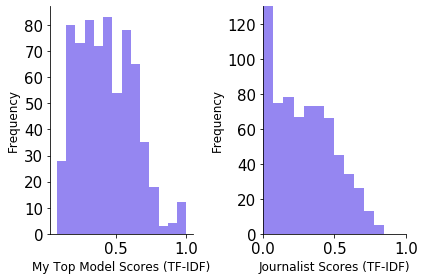

In [17]:
# create a figure and axes
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(val_tfidf['MyModel'], bins='auto', alpha=0.8, color="mediumslateblue")
#removing top and right borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#labelling x and y axes
ax1.set_xlabel('My Top Model Scores (TF-IDF)', fontsize=12) #labelling x and y axes
ax1.set_ylabel('Frequency', fontsize=12)


ax2.hist(val_tfidf['JournalScore'], bins='auto', alpha=0.8, color="mediumslateblue")
#removing top and right borders
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#labelling x and y axes
ax2.set_xlabel('Journalist Scores (TF-IDF)', fontsize=12) 
ax2.set_ylabel('Frequency', fontsize=12)


plt.subplots_adjust(bottom=0.1, right=1.2, top=0.9)
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

#Setting x and y limits
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 130)

#Adjusting margins
plt.tight_layout()

plt.savefig("TFIDF_Distribution.pdf", transparent = True)

##### Fig 2. Distribution of cosine similairty scores (computed from TF-IDF vectors) for the top similar story identified by News-Link and stories selected by journalists. 

Some observations:

* 33% of the time News-Link is able to identify stories that have the same similarity score as those inserted by journalists

* The majority of the time News-Link identifies stories that are more similar to a story of interest than those inserted by journalists.

* There is a higher frequency of low similarity stories inserted by journalists, than those selected by News-Link

* The corpus contains some duplicate stories, given that News-Link pulls out stories with a cosine similarity of one (likely due to changes to story titles and urls after publication).

#### GloVe Embeddings & Cosine Similarity Score

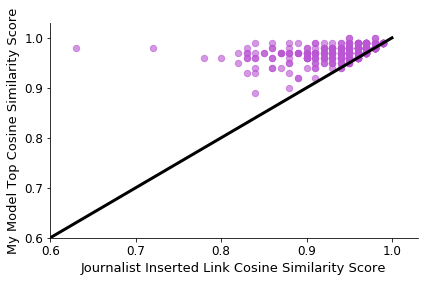

In [18]:
#Creating a figure and axes
fig, ax = plt.subplots()

#scatter my similarity scores against the similarity scores for journalist inserted articles
ax.scatter(val_glove['JournalScore'], val_glove['MyModel'], 
           c='mediumorchid', alpha = 0.6, s=40)
#Setting x and y limits
plt.xlim(0.6, 1.03)
plt.ylim(0.6, 1.03)

#Adjusting axes
plt.rc('axes', labelsize=10)  # ontsize of the x and y labels
plt.rc('xtick', labelsize=15) # fontsize of the tick labels
plt.rc('ytick', labelsize=15) # fontsize of the tick labels

ax.set_xlabel('Journalist Inserted Link Cosine Similarity Score', fontsize=13)
ax.set_ylabel('My Model Top Cosine Similarity Score', fontsize = 13)

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 

#Adding 1:1 line on plot 
plt.plot([0, 1.0], [0, 1.0], color='black', linestyle='-', linewidth=3)

#Adjusting margins
plt.tight_layout()

#Saving plot
plt.savefig("News_Glove_Scatter.pdf", transparent = True)

##### Fig 3. Comparison of cosine similairty scores (computed from GloVe embeddings) for links inserted by journalits to the top similar story identied by News-Link

In [75]:
#Subsetting dataframe to include only rows where News-Link and Journalist scores are the same
equal = val_glove.loc[(val_glove['JournalScore'] == val_glove['MyModel'])]
#Calculating percentage of scores that match.

print((len(equal)/len(val_glove))*100)


30.0


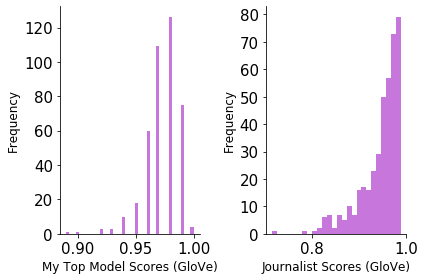

In [19]:
# create a figure and axes
fig, (glove1, glove2) = plt.subplots(1,2)

glove1.hist(val_glove['MyModel'], bins='auto', alpha=0.8, color="mediumorchid")
#removing top and right borders
glove1.spines['top'].set_visible(False)
glove1.spines['right'].set_visible(False)
#labelling x and y axes
glove1.set_xlabel('My Top Model Scores (GloVe)', fontsize=12) #labelling x and y axes
glove1.set_ylabel('Frequency', fontsize=12)


glove2.hist(val_glove['JournalScore'], bins='auto', alpha=0.8, color="mediumorchid")
#removing top and right borders
glove2.spines['top'].set_visible(False)
glove2.spines['right'].set_visible(False)


#labelling x and y axes
glove2.set_xlabel('Journalist Scores (GloVe)', fontsize=12) 
glove2.set_ylabel('Frequency', fontsize=12)


plt.subplots_adjust(bottom=0.1, right=1.2, top=0.9)
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

#Setting x and y limits
plt.xlim(0.7, 1.0)
#plt.ylim(0.0, 130)

#Adjusting margins
plt.tight_layout()

plt.savefig("GloveCosine_Distribution.pdf", transparent = True)

##### Fig 4. Distribution of cosine similairty scores (computed from GloVe embeddings) for the top similar story identified by News-Link and stories selected by journalists. 

Some observations:

* 30% of the time News-Link is able to identify stories that have the same similarity score as those inserted by journalists

* The majority of the time News-Link identifies stories that are more similar to a story of interest than those inserted by journalists.

* Using GloVe embeddings returns higher similarity scores for both journalist and News-Link identified stories than using TF-IDF.

* As with TF-IDF there is more variability in the similaritiy scores of journalists


#### GloVe Embeddings & Word Mover's Distance

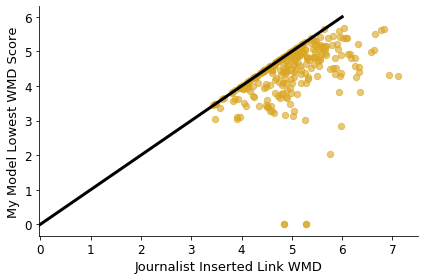

In [20]:
#Creating a figure and axes
fig, ax = plt.subplots()

#scatter my similarity scores against the similarity scores for journalist inserted articles
ax.scatter(val_wmd['JournalScore'], val_wmd['MyModel'], 
           c='goldenrod', alpha = 0.6, s=40)

#Setting x and y limit
plt.xlim(-0.03,7.5)
#plt.ylim(-0.03,6)

#Adjusting axes
plt.rc('axes', labelsize=10)  # ontsize of the x and y labels
plt.rc('xtick', labelsize=15) # fontsize of the tick labels
plt.rc('ytick', labelsize=15) # fontsize of the tick labels

ax.set_xlabel('Journalist Inserted Link WMD', fontsize=13)
ax.set_ylabel('My Model Lowest WMD Score', fontsize = 13)

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 

#Adding 1:1 line on plot 
plt.plot([-0.03, 6.0], [-0.03, 6.0], color='black', linestyle='-', linewidth=3)

#Adjusting margins
plt.tight_layout()

#Saving plot
plt.savefig("News_WMD_Scatter.pdf", transparent = True)

##### Fig 6. Comparison of WMD scores (computed from GloVe embeddings) for links inserted by journalits to the top similar story identied by News-Link. 

In [95]:
#Subsetting dataframe to include only rows where News-Link and Journalist scores are the same
equal_wmd = val_wmd.loc[(val_wmd['JournalScore'] == val_wmd['MyModel'])]
#Calculating percentage of scores that match.

print((len(equal_wmd)/len(val_wmd))*100)


29.044117647058826


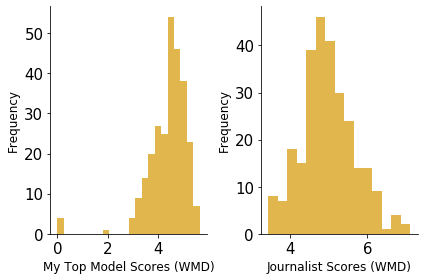

In [21]:
# create a figure and axes
fig, (wmd1, wmd2) = plt.subplots(1,2)

wmd1.hist(val_wmd['MyModel'], bins='auto', alpha=0.8, color="goldenrod")
#removing top and right borders
wmd1.spines['top'].set_visible(False)
wmd1.spines['right'].set_visible(False)
#labelling x and y axes
wmd1.set_xlabel('My Top Model Scores (WMD)', fontsize=12) #labelling x and y axes
wmd1.set_ylabel('Frequency', fontsize=12)


wmd2.hist(val_wmd['JournalScore'], bins='auto', alpha=0.8, color="goldenrod")
#removing top and right borders
wmd2.spines['top'].set_visible(False)
wmd2.spines['right'].set_visible(False)


#labelling x and y axes
wmd2.set_xlabel('Journalist Scores (WMD)', fontsize=12) 
wmd2.set_ylabel('Frequency', fontsize=12)


plt.subplots_adjust(bottom=0.1, right=1.2, top=0.9)
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

#Adjusting margins
plt.tight_layout()

plt.savefig("GloveWMD_Distribution.pdf", transparent = True)

##### Fig 7. Distribution of WMD scores (computed from GloVe embeddings) for the top similar story identified by News-Link and stories selected by journalists. 

Some observations: 

**Note: Unlike cosine similarity score, lower values of WMD indicate more similar articles**

* 30% of the time News-Link is able to identify stories that have the same WMD score as those inserted by journalists

* The majority of the time News-Link identifies stories that have a lower WMD score (are more similar to a story) than those inserted by journalists.

* As with TF-IDF and GloVe with cosine similarity there is more variability in the similaritiy scores of journalists.


### Behavioural Survey Results

In order to understand how the average reader might feel about the similarity of selected links, I put together a short survey which I then administered to the Insight Data Science Toronto Office. As part of this survey, participants were asked to read three short news stories. After reading the stories they were provided with several possible realted headlines. Each one of these headlines for "similar" news stories was selected using a different method: journalist heuristic, TF-IDF and cosine simialrity, GloVe embeddings and cosine simialrity, and GloVe embeddings and word mover's distance. Given that only 17 individuals completed this survey, I did not analyze the results for statistical signfigance, but present a graphical representation below:

In [23]:
#Loading in the results of the survey
survey = round(pd.read_csv('/Users/Cylita/Desktop/insight-ds-project_news-link/data/cleaned/survey_results.csv'), 2)

In [52]:
#Creating labels for all plots
labels = ["Journalist", "TF-IDF", "GloVe", "WMD", "All Similar", "None Similar"]
colors = ['orangered', 'mediumslateblue', 'darkolivegreen', 'goldenrod', 'darkorchid', 'gray']

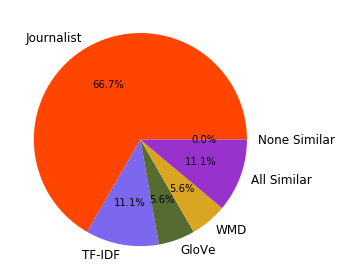

In [53]:
# create a figure and axes
fig, story1 = plt.subplots()

story1.pie(round(survey["Story_1"],0), labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False)
#Adjusting margins
plt.tight_layout()

plt.savefig("Pie_Chart_Survey1.pdf", transparent = True)

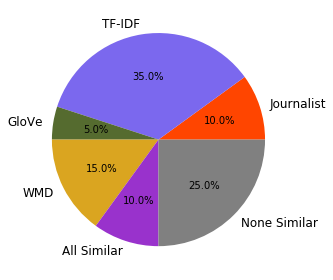

In [54]:
# create a figure and axes
fig, story2 = plt.subplots()

story2.pie(round(survey["Story_2"],0), labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False)
#Adjusting margins
plt.tight_layout()

plt.savefig("Pie_Chart_Survey2.pdf", transparent = True)

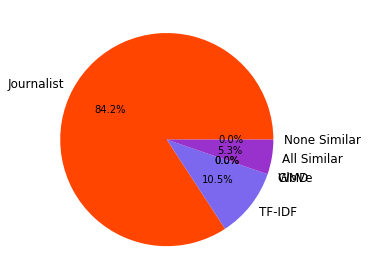

In [55]:
# create a figure and axes
fig, story3 = plt.subplots()

story3.pie(round(survey["Story_3"],0), labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False)
#Adjusting margins
plt.tight_layout()

plt.savefig("Pie_Chart_Survey3.pdf", transparent = True)

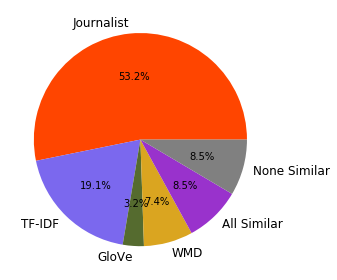

In [56]:
# create a figure and axes
fig, story4 = plt.subplots()

story4.pie(round(survey["Percent_Total"],0), labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False)
#Adjusting margins
plt.tight_layout()

plt.savefig("Pie_Chart_Survey4.pdf", transparent = True)

Some insights:

* Most people appear to prefer journalist selected links (but most links selected by journalists were also in the top of TF-IDF selected links).

* TF-IDF appears to be the next best method for selecting similar links

* ~10% of folks think all methods do an adequate job